In [7]:
from utils.plotting import plot_behavior, plot_pca
from utils.sequences import add_task_identity
from utils.analysis import get_all_hiddens, minimize_speed, get_attractors
from utils.rnn import MultitaskRNN, get_model, run_model

import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Network behavior

In [8]:
task_names = ['DelayGo']
num_hidden = 256
seed = 2
lr = -7
dt = 20
tau = 100

hparams = {
    'batch_size': 64, 
    'learning_rate': 10**(lr/2),
    'sigma_x': 0.1,
    'alpha': dt/tau,
    'sigma_rec': 0.05,
    'activation': 'softplus',
    'w_in_coeff': 1.0,
    'w_rec_coeff': 0.9, 
    'w_rec_init': 'diag',
    'l1_lambda': 0.0,
    'l2_lambda': 1e-7,
    'l1_h_lambda': 0.0,
    'l2_h_lambda': 1e-7,
    'seed': seed
}

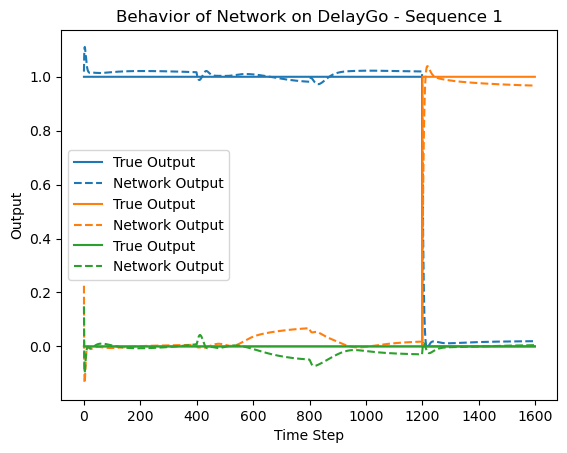

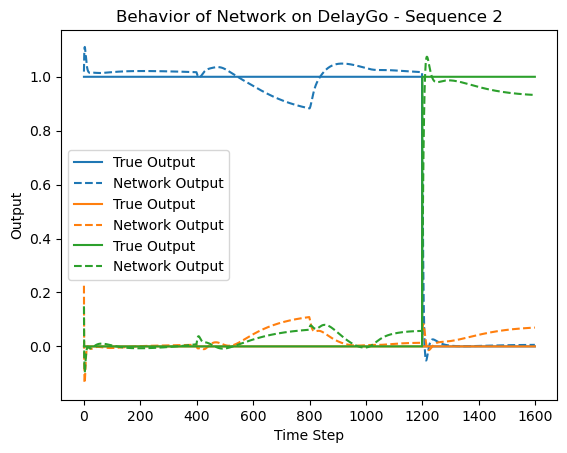

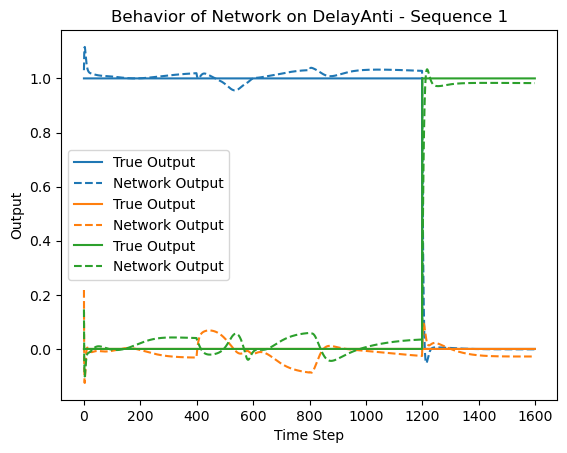

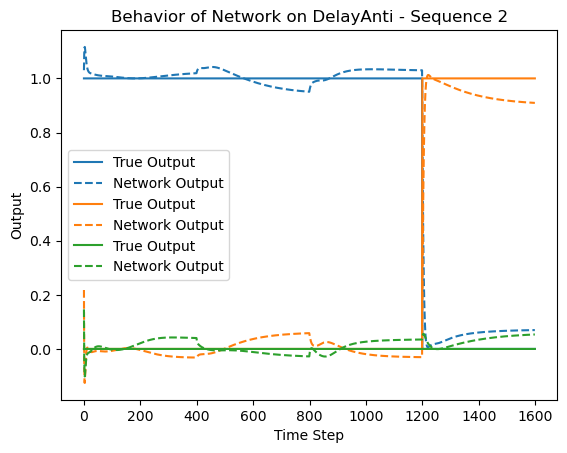

In [31]:
period_duration=400
plot_behavior(task_names, num_hidden, hparams, period_duration=period_duration)

# Fixed Points

In [32]:
rnn, tasks = get_model(task_names, num_hidden, hparams)

all_hiddens = get_all_hiddens(rnn, tasks)

period = "delay"
stimulus = 2
task_idx = 0

input = add_task_identity(tasks[task_idx].get_input(period, stimulus), task_idx, len(tasks))
input

tensor([1., 0., 0., 1., 0.])

In [33]:
num_timesteps = 10000
num_last = 100

attractors = get_attractors(rnn, input, all_hiddens, num_timesteps, num_last)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


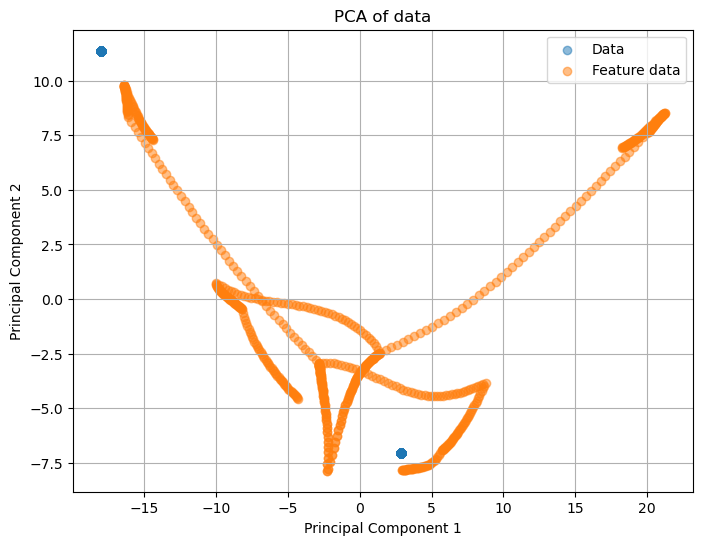

In [34]:
# Usage example
attractors_2d = attractors.reshape(-1, attractors.shape[-1])
plot_pca(attractors_2d.detach().numpy(), all_hiddens.detach().numpy(), plot_feature_data=True)  # convert tensors to numpy arrays for use with sklearn

In [11]:
inputs

tensor([[1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0.],
        ...,
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0.]])